In [23]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import timeit
import sys
import os
from sklearn.cross_validation import KFold
from collections import OrderedDict
import operator
import random
from sklearn.cluster import KMeans
import numpy as np
import scipy.linalg as LA
import scipy.sparse
import sklearn.utils.arpack as SLA
from sklearn.base import ClassifierMixin
from sklearn.base import BaseEstimator
from sklearn.manifold import spectral_embedding
from pyspark.mllib.clustering import GaussianMixture, GaussianMixtureModel
import sklearn.metrics.pairwise as pairwise
from sklearn import decomposition as pca
from scipy import interpolate as ip
import sklearn.mixture as mixture
import sys
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.neighbors import DistanceMetric
from pyspark.sql import SQLContext
from pyspark.sql.types import *
%matplotlib inline

dataX,dataY=datasets.make_blobs(n_samples=20000, n_features=4, centers=2, cluster_std=1.5, center_box=(-10.0, 10.0), shuffle=True, random_state=None)

def labelremover(X,y):
    newX1 = np.around(X,decimals=2)
    newY1=np.copy(y)
    dim = X.shape[1]
    points = np.array(np.empty(len(np.unique(y))))
    knownX = np.empty((len(points),dim))
    knownY = np.empty(len(points))
    for i in np.unique(y):
        points[i] = np.where(y==(i))[0][0]
    for j in np.arange(0,len(newY1)):
        newY1[j]=-1
    for k in np.unique(y):
        newY1[points[k]] = y[points[k]]
    knownX = X[[i for i in points]]
    knownY = y[[i for i in points]]
    print "These are labels of known points: "+ str(knownY)
    return (newY1, knownX, knownY)

trainX = dataX[0:18000,:]
trainY = dataY[0:18000]
testX = dataX[18000:20000,:]
testY = dataY[18000:20000]


newtrainY, knownX, knownY = labelremover(trainX,trainY)


These are labels of known points: [0 1]


/home/madhura/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [46]:
#Standalone code
X = trainX
y = newtrainY

classes = np.sort(np.unique(y))
PCA = pca.PCA(n_components=X.shape[1])
rotatedData = PCA.fit_transform(X)

#plt.scatter(rotatedData[:,0], rotatedData[:,1], c=trainY, cmap = (('ocean')))

X_ = rotatedData

dim = X_.shape[1]
classes = np.delete(classes, 0) # remove the -1 from this list
k = np.size(classes)

numBins =k+1

def _get_kernel(X, y = None,ker=None):
    
    if ker == "rbf":
        if y is None:
            return pairwise.rbf_kernel(X, X, gamma = 625)
        else:
            return pairwise.rbf_kernel(X, y, gamma = 625)
    elif ker == "linear":
        
        dist = DistanceMetric.get_metric('euclidean')
        if y is None:
            return pairwise.euclidean_distances(X, X)
            #return dist.pairwise(X)
        else:
            return pairwise.euclidean_distances(X, y)
            #return dist.pairwise(X)
    else:
        raise ValueError("is not a valid kernel. Only rbf and euclidean"
                         " are supported at this time")


sig = np.zeros(dim)
gee = np.zeros((numBins,dim))
b_edgeMeans = np.zeros((numBins,dim))
interpolators = []
index = []


for i in range(dim):
    histograms,binEdges = np.histogram(X_[:,i],bins=numBins,density=True)
    #add 0.01 to histograms and normalize it
    histograms = histograms+ 0.01
    #print histograms
    histograms /= histograms.sum()
    # calculating means on the bin edges as the x-axis for the interpolators
    b_edgeMeans[:,i] = np.array([binEdges[j:j + 2].mean() for j in range(binEdges.shape[0] - 1)])
    #print b_edgeMeans
    #get D~, P, W~
    '''
    Wdis = Affinity between discrete points.
    Since Affinity matrix will be build on one histogram at a time. I am using pairwise linear- kernel affinities
    P  = Diagonal matrix of histograms
    Ddis = Diagonal matrix whose diagonal elements are the sum of the columns of PW~P
    Dhat = Diagonal matrix whose diagonal elements are the sum of columns of PW~
    '''
    Wdis = _get_kernel(histograms.reshape(histograms.shape[0],1),y=None,ker="linear")
    #print Wdis
    P  = np.diag(histograms)
    #print P
    Ddis = np.diag(np.sum((P.dot(Wdis.dot(P))),axis=0))
    #print Ddis
    Dhat = np.diag(np.sum(P.dot(Wdis),axis=0))
    #print Dhat
    #Creating generalized eigenfunctions and eigenvalues from histograms.
    sigmaVals, functions = scipy.linalg.eig((Ddis-(P.dot(Wdis.dot(P)))),(P.dot(Dhat)))
    #print functions.shape
    #print("eigenValue"+repr(i)+": "+repr(np.real(sigmaVals[0:self.k]))+"Eigenfunctions"+repr(i)+": "+repr(np.real(functions[:,0:self.k])))
    #print np.sort(np.real(sigmaVals))
    arg = np.argsort(np.real(sigmaVals))[1]
    index.append(arg)
    sig[i] = np.real(sigmaVals)[arg]
    gee[:,i] = np.real(functions)[:,arg]
    #b_edge_for_test[:,i] = b_edgeMeans[:,arg]
    #print "===="
'''for i in index:
    plt.hist(X_[:,i], bins = numBins)
    plt.axis([binEdges.min()-5, binEdges.max()+5, 0, X_.shape[0]])
plt.show()
'''

if np.isnan(np.min(sig)):
    nan_num = np.isnan(sig)
    sig[nan_num] = 0
newsig = np.zeros(k)
newg = np.zeros((numBins,k))
newEdgeMeans = np.zeros((numBins,k))
transformeddata = np.zeros((X_.shape[0],k))
approxValues = np.zeros((X_.shape[0],k))

def get_transformed_data(ori_data,edge_means,i):
    dim = edge_means.shape[1]
    transformeddata = np.empty((ori_data.shape[0],dim))
    if ori_data[:,i].min() < edge_means[:,i].min() or ori_data[:,i].max() > edge_means[:,i].max():
        ls=[]
        for num in ori_data[:,i]:
            val = (((edge_means[:,i].max()-edge_means[:,i].min())*(num - ori_data[:,i].min()))/(ori_data[:,i].max() - ori_data[:,i].min())) + edge_means[:,i].min()
            if num==ori_data[:,i].min():
                val = val + 0.001
            if num==ori_data[:,i].max():
                val = val - 0.001
            ls.append(val)
        return np.array(ls)
        #transformeddata[i,:] = transformer(b_edgeMeans[i].min(), b_edgeMeans[i].max(), self.X_[:,i])
    else:
        print("within range")
        return ori_data[:,i]
#selecting the first k eigenvalues and corresponding eigenvectors from all dimensions

ind =  np.argsort(sig)[0:k]
print ind
newsig = sig[ind]
newg = gee[:,ind]
newEdgeMeans = b_edgeMeans[:,ind]
allinterpolators = []
b_edge_for_test = np.zeros((numBins,dim))
for i in range(0,k):
    interpolators.append(ip.interp1d(newEdgeMeans[:,i], newg[:,i]))
    transformeddata[:,i] = get_transformed_data(X_,newEdgeMeans,i)
    approxValues[:,i] = interpolators[i](transformeddata[:,i])

U = approxValues
S = np.diag(newsig)
V = np.diag(np.zeros(np.size(y)))

labeled = np.where(y != -1)
V[labeled, labeled] = 10

# Solve for alpha and use it to compute the eigenfunctions, f.
A = S + np.dot(np.dot(U.T, V), U)
if np.linalg.det(A) == 0:
    A = A + np.eye(A.shape[1])*0.000001
b = np.dot(np.dot(U.T, V), y)
#print "this is A: "+ str(A)
#print "this is b: "+ str(b)
alpha = np.linalg.solve(A, b)

#labels_ = solver(U, alpha)
f = np.dot(U,alpha)
f = f.reshape((f.shape[0],-1))
# Set up a GMM to assign the hard labels from the eigenfunctions.
g = mixture.GMM(n_components = np.size(classes),n_iter=5000, covariance_type='full',min_covar=0.0000001)
g.fit(f)
labels_ = g.predict(f)

means = np.argsort(g.means_.flatten())

for i in range(0, np.size(labels_)):
    labels_[i] = np.where(means == labels_[i])[0][0]

#===========================================================================
#predict
tx = PCA.transform(testX)
approxVec1 = np.zeros((tx.shape[0],k))
allpoints = np.zeros((tx.shape[0],k))
for i in range(k):
    allpoints[:,i] = get_transformed_data(tx[:,0:k], newEdgeMeans,i)
#print allpoints
for p in range(tx.shape[0]):
    kpoints = allpoints[p]
    #print kpoints
    for d in range(len(kpoints)):
        val = kpoints[d]
        approxVec1[p,d] = interpolators[d](val)


tf = np.dot(approxVec1,alpha)
tf = tf.reshape((tf.shape[0],-1))
tlabels_ = g.predict(tf)
for i in range(0, np.size(tlabels_)):
    tlabels_[i] = np.where(means == tlabels_[i])[0][0]

#===========================================================================



[3 1]


In [73]:
#Distributed code

%run LabelPropagationDistributed.ipynb

lpd = LabelPropagationDistributed(numBins=3)

dX = sc.parallelize(trainX)
dy = sc.parallelize(newtrainY)
lpd.fit(dX,dy)

#plabels_ = lpd.predict(sc.parallelize(testX))

<__main__.LabelPropagationDistributed instance at 0x7f122566a830>

In [47]:
print "standalone k smallest eigenvalues: " ,newg
print "distributed k smallest eigenvectors: ", lpd.newg
print "====================================================\n"
print "binEdges:", binEdges
print "dist binedges:", lpd.ori_edgem
print "hist edgemeans:", b_edgeMeans
print "dist edgemeans:", lpd.b_edgeMeans
print "ind is:", ind
print "dist ind is:", lpd.ind
print "edgemeans are:", newEdgeMeans
print "dist edgemeans are:", lpd.newEdgeMeans
print "====================================================\n"
print "U is:", U
print "dist U is:", lpd.U1.toLocalMatrix().toArray()
print "S is:", S
print "dist S is:", lpd.S
print "V is:", V
print "dist V is:", lpd.V.entries.collect()
print "====================================================\n"
print "A is: ", A
print "dist A is: ", lpd.A1
print "b is: ",b
print "dict b is: ", lpd.b1
print "====================================================\n"
print "standalone alpha is:", alpha
print "distributed alpha is ", lpd.alphab.toLocalMatrix().toArray().flatten()
print "====================================================\n"
print "eigenfunctions are:", f
print "dist eigenfunctions are:", lpd.ec.take(20)

standalone k smallest eigenvalues:  [[  6.91444971e-01   7.54052689e-01]
 [  2.23911556e-05  -2.75593022e-04]
 [ -7.22429133e-01  -6.56813875e-01]]
distributed k smallest eigenvectors:  [[  7.22429133e-01   7.54052689e-01]
 [ -2.23911557e-05  -2.75593022e-04]
 [ -6.91444970e-01  -6.56813875e-01]]

binEdges: [-5.94688392 -1.97235491  2.0021741   5.97670311]
dist binedges: [-5.61972189 -1.64519294  2.32933601  6.30386496]
hist edgemeans: [[-8.1044855  -3.96296024 -4.33774946 -3.95961941]
 [ 0.01700681 -0.09218831 -0.3190924   0.01490959]
 [ 8.13849912  3.77858362  3.69956465  3.9894386 ]]
dist edgemeans: [[ -4.61074448   3.68176723  -2.9809645   -3.63245742]
 [  3.51074791   7.55253911   1.03769255   0.34207153]
 [ 11.6322403   11.423311     5.0563496    4.31660048]]
ind is: [3 1]
dist ind is: [3 1]
edgemeans are: [[-3.95961941 -3.96296024]
 [ 0.01490959 -0.09218831]
 [ 3.9894386   3.77858362]]
dist edgemeans are: [[ -3.63245742   3.68176723]
 [  0.34207153   7.55253911]
 [  4.31660048  

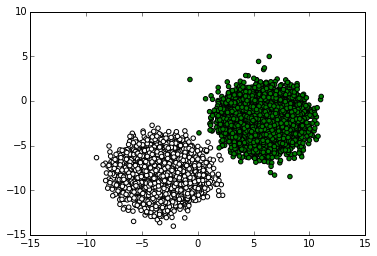

In [27]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=trainY, cmap = ('ocean'))

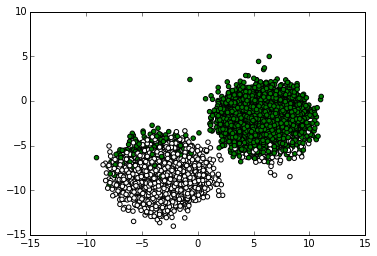

In [28]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=labels_, cmap = ('ocean'))

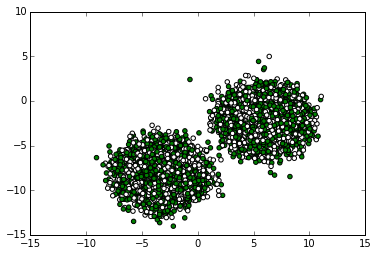

In [62]:
plt.scatter(trainX[:, 0], trainX[:, 1], marker='o', c=g.predict(lpd.ec.collect()), cmap = ('ocean'))

In [31]:
shit = lpd.joined.collect()
tmparr = np.zeros((18000,4))
print len(shit)
i=0
tmplab = np.zeros(18000)
for (a,b) in shit:
    tmparr[i] = a
    tmplab[i] = b
    i = i+1
from sklearn import metrics
ss = metrics.silhouette_score(tmparr,tmplab,metric='euclidean')
ss

18000


1.2444157878749523e-05

In [54]:
tl = lpd.ec.map(lambda x: x[0]).collect()
tl

[-0.75536878408025054,
 0.30917140376469526,
 0.40345236669244777,
 0.11991082511964865,
 0.72856594456124846,
 -0.51090325150779314,
 0.44468743404205929,
 0.15010169896481085,
 -0.060946552191953995,
 -0.66035814500344958,
 0.22027309633079906,
 -0.030929002686384266,
 0.2119686473094681,
 0.38670964937073626,
 0.88697705974406627,
 -0.39266486548660928,
 -0.053938985371667303,
 0.48366352149174685,
 0.48064805051587112,
 0.15852321633873762,
 -0.0073521589050158931,
 0.2948584402347445,
 0.29401535661306732,
 -0.28030183250273039,
 0.48703814244493826,
 -0.58582807519322455,
 -0.23582767316494146,
 0.40002734404980239,
 0.33169180577010438,
 0.61109114291813993,
 -0.031339362452047603,
 -0.46979279232957305,
 -0.63928992059540135,
 -0.066300825407272002,
 0.71911160100444593,
 -0.22599907217132359,
 0.18336888899110854,
 -0.40484859635778619,
 0.63956511752094003,
 0.74294186906132464,
 0.27956309734606311,
 0.23465458151493346,
 -0.31085270269312343,
 -0.45035526656688074,
 0.53289

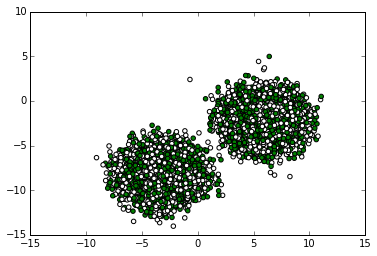

In [68]:
plt.scatter(trainX[:,0], trainX[:, 1], marker='o', c=lpd.labels_.collect(), cmap = ('ocean'))

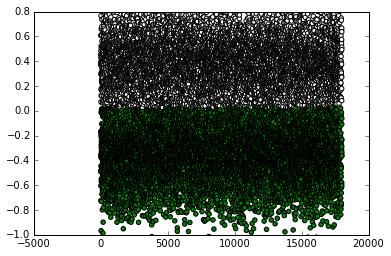

In [33]:
plt.axis([-5000,20000,-1.0,0.8])
plt.scatter(range(len(f)),f, marker='o', c=labels_,cmap=('ocean'))

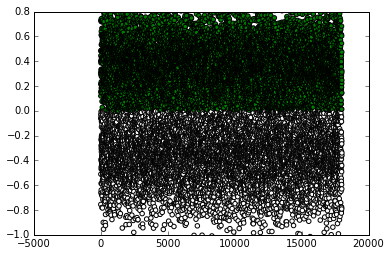

In [36]:
plt.axis([-5000,20000,-1.0,0.8])
plt.scatter(range(len(tl)),tl, marker='o', c=lpd.labels_.collect(),cmap=('ocean'))